In [28]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   

## Mean-variance optimisation (sharpe ratio optimisation)

In [2]:
def get_data(tickers, start_date, end_date):
    """Récupère les données historiques des actifs"""
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close']
    return data


def compute_rolling_volatility(value, window):
    """Calcule la volatilité glissante"""
    returns = np.diff(np.log(value), n=1, axis=0)
    volatility = np.lib.stride_tricks.sliding_window_view(
        returns, window_shape=window, axis=0
    ).std(axis=-1)
    return volatility * np.sqrt(252)

def calculate_portfolio_metrics(returns, weights):
    """Calcule les métriques du portefeuille"""
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_vol
    return portfolio_return, portfolio_vol, sharpe_ratio

def optimize_portfolio(returns, risk_free_rate=0):
    """Optimise le portefeuille selon Markowitz"""
    n = returns.shape[1]
    
    def objective(weights):
        portfolio_return, portfolio_vol, sharpe_ratio = calculate_portfolio_metrics(returns, weights)
        return -sharpe_ratio  # On maximise le ratio de Sharpe
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somme des poids = 1
    )
    bounds = tuple((0, 1) for _ in range(n))  # Contraintes sur les poids
    initial_weights = np.array([1/n] * n)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

def backtest_strategy(data, lookback=252, transaction_cost=0.0001):
    """Backteste la stratégie avec rebalancement journalier"""
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    portfolio_values = []
    weights_history = []
    current_weights = np.array([1/n_assets] * n_assets)
    
    # Initialisation
    portfolio_value = 1
    
    for t in range(lookback, len(returns)):
        # Données historiques pour l'optimisation
        historical_returns = returns.iloc[t-lookback:t]
        
        # Optimisation des nouveaux poids
        new_weights = optimize_portfolio(historical_returns)
        
        # Calcul des coûts de transaction
        trading_costs = np.sum(np.abs(new_weights - current_weights)) * transaction_cost
        
        # Mise à jour de la valeur du portefeuille
        daily_return = np.sum(returns.iloc[t] * current_weights) - trading_costs
        portfolio_value *= (1 + daily_return)
        
        portfolio_values.append(portfolio_value)
        weights_history.append(new_weights)
        current_weights = new_weights
    
    return portfolio_values, np.array(weights_history)



In [24]:
# Paramètres
tickers = ['AGG', 'DBC', 'VTI', '^VIX']
start_date = "2011-01-01"
end_date = "2020-04-30"

# Récupération des données
data = get_data(tickers, start_date, end_date)

# Backtest de la stratégie
portfolio_values, weights_history = backtest_strategy(data)

# Calcul des métriques finales
returns = pd.Series(portfolio_values).pct_change().dropna()
return_mean = returns.mean() * 252 * 100
volatility = returns.std() * np.sqrt(252) * 100
sharpe_ratio = return_mean / (volatility)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


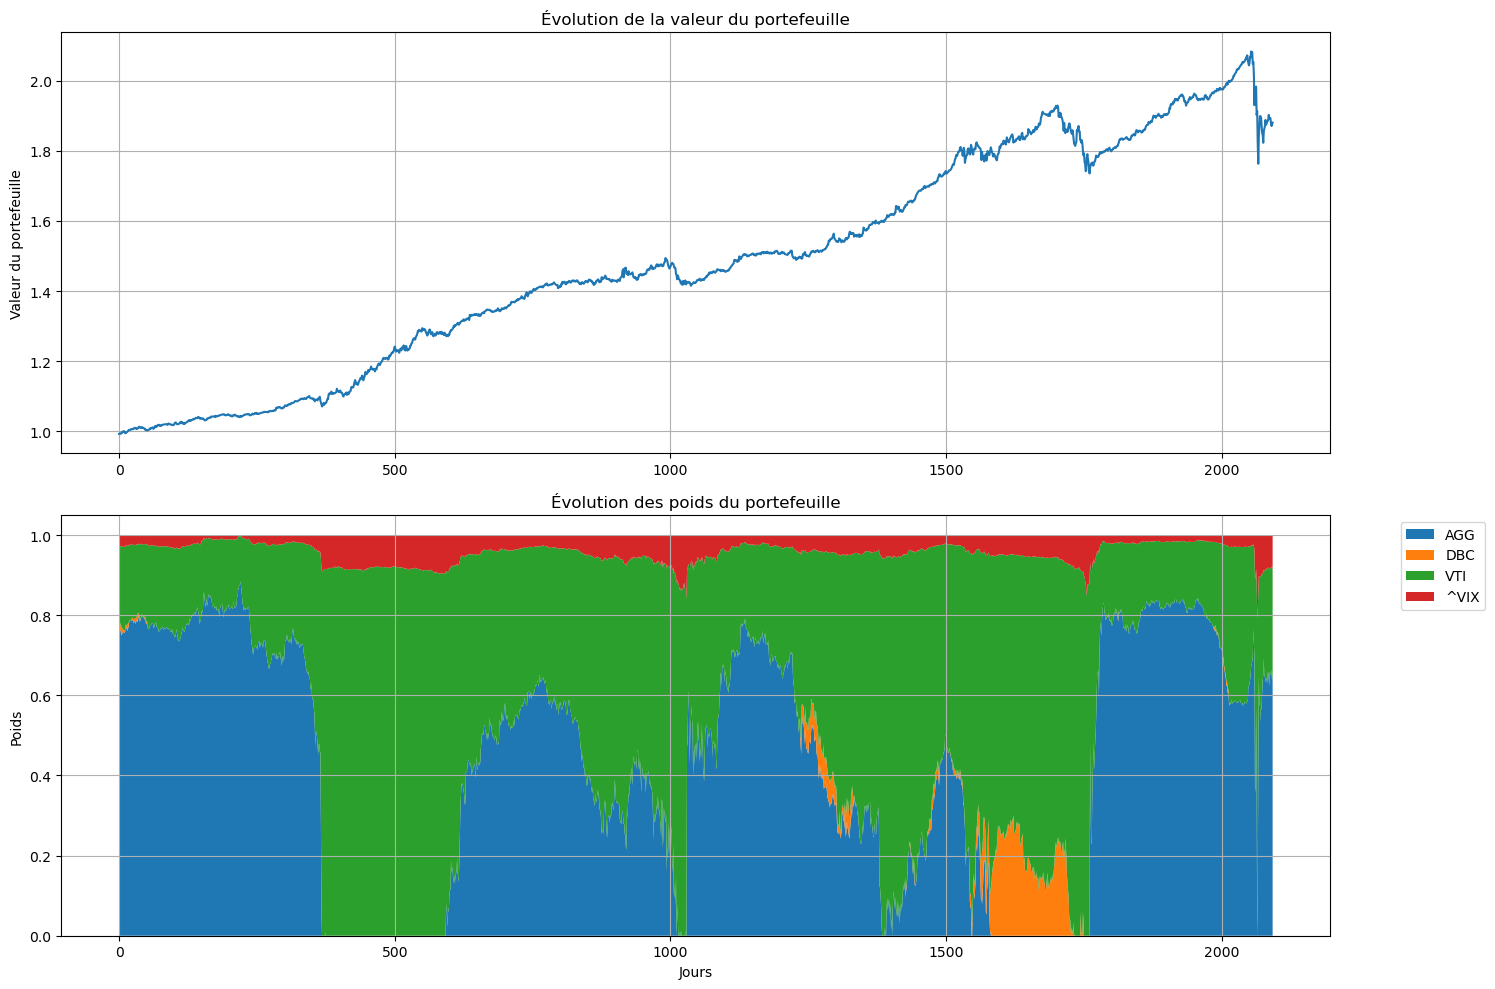

In [27]:

plt.figure(figsize=(15, 10))

# Plot 1: Évolution de la valeur du portefeuille
plt.subplot(2, 1, 1)
plt.plot(portfolio_values)
plt.title('Évolution de la valeur du portefeuille')
plt.ylabel('Valeur du portefeuille')
plt.grid(True)

# Plot 2: Évolution des poids
plt.subplot(2, 1, 2)
weights_df = pd.DataFrame(weights_history, columns=tickers)
plt.stackplot(range(len(weights_history)), weights_df.T, labels=tickers)
plt.title('Évolution des poids du portefeuille')
plt.xlabel('Jours')
plt.ylabel('Poids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
print(f"Performance totale: {return_mean:.2f}%")
print(f"Volatilité annualisée: {volatility:.2f}%")
print(f"Ratio de Sharpe: {sharpe_ratio:.2f}")

Performance totale: 7.86%
Volatilité annualisée: 5.91%
Ratio de Sharpe: 1.33


In [44]:
def backtest_with_vol_control(data, lookback=252, vol_window=50, target_volatility=0.1, 
                            transaction_cost=0.0001, rebalancing_freq='yearly'):

    returns = data.pct_change().dropna()
    spot = data.values
    N = len(spot)
    d = spot.shape[1]
    years = (data.index[-1] - data.index[0]).days / 365.25
    t = np.linspace(0, years, N)
    
    # Calcul des indices de rebalancement
    if rebalancing_freq == 'yearly':
        rebal_indices = np.arange(0, N, 252)
    elif rebalancing_freq == 'monthly':
        rebal_indices = np.arange(0, N, 21)
    else:  # daily
        rebal_indices = np.arange(0, N)
    
    # Initialisation des arrays
    portfolio_value_controlled = np.ones(N)
    weights_actual = np.zeros((N, d+1))  # +1 pour le cash
    rebalancing_costs = np.zeros(N)
    
    # Première optimisation
    if lookback >= len(returns):
        weights_actual[0, :-1] = np.array([1/d] * d)
    else:
        weights_actual[0, :-1] = optimize_portfolio(returns.iloc[:lookback])
    
    # Simulation
    for t in range(1, N):
        # Optimisation si jour de rebalancement
        if t in rebal_indices and t >= lookback:
            hist_returns = returns.iloc[t-lookback:t]
            current_weights = optimize_portfolio(hist_returns)
        else:
            current_weights = weights_actual[t-1, :-1]
        
        # Calcul de la volatilité réalisée
        if t < vol_window:
            realized_vol = target_volatility
        else:
            realized_vol = compute_rolling_volatility(spot[t-vol_window:t+1], vol_window)[-1]
        
        # Ajustement des poids pour le contrôle de la volatilité
        vol_scaling = target_volatility / realized_vol
        scaled_weights = current_weights * vol_scaling
        scaled_weights = scaled_weights / np.maximum(1, scaled_weights.sum())
        
        # Calcul des coûts de transaction
        rebalancing_costs[t] = portfolio_value_controlled[t-1] * \
            np.abs(scaled_weights - weights_actual[t-1, :-1]).sum() * transaction_cost
        
        # Mise à jour des poids et valeurs
        daily_returns = (spot[t] / spot[t-1] - 1)
        portfolio_return = daily_returns @ scaled_weights
        
        weights_actual[t, :-1] = (spot[t] / spot[t-1]) * scaled_weights
        weights_actual[t, :-1] /= np.maximum(1, weights_actual[t, :-1].sum())
        weights_actual[t, -1] = 1 - weights_actual[t, :-1].sum()  # cash
        
        portfolio_value_controlled[t] = (portfolio_value_controlled[t-1] - rebalancing_costs[t]) * \
            (1 + portfolio_return)
    
    # Calcul des volatilités
    volatility = compute_rolling_volatility(spot, vol_window)
    portfolio_volatility_controlled = compute_rolling_volatility(
        portfolio_value_controlled.reshape(-1, 1), vol_window)
    
    return portfolio_value_controlled, weights_actual

In [48]:
# Paramètres
tickers = ['AGG', 'DBC', 'VTI', '^VIX']
start_date = "2011-01-01"
end_date = "2020-04-30"

data = get_data(tickers, start_date, end_date)

# Backtest de la stratégie
portfolio_value_controlled, weights_actual = backtest_with_vol_control(data, lookback=252, vol_window=50, target_volatility=0.1, 
                            transaction_cost=0.0001, rebalancing_freq='daily')


# Calcul des métriques 
returns_vol = pd.Series(portfolio_value_controlled).pct_change().dropna()
returns_vol_mean = returns_vol.mean() * 252 * 100
volatility_cont = returns_vol.std() * np.sqrt(252) * 100
sharpe_ratio_vol = returns_vol_mean / (volatility_cont)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


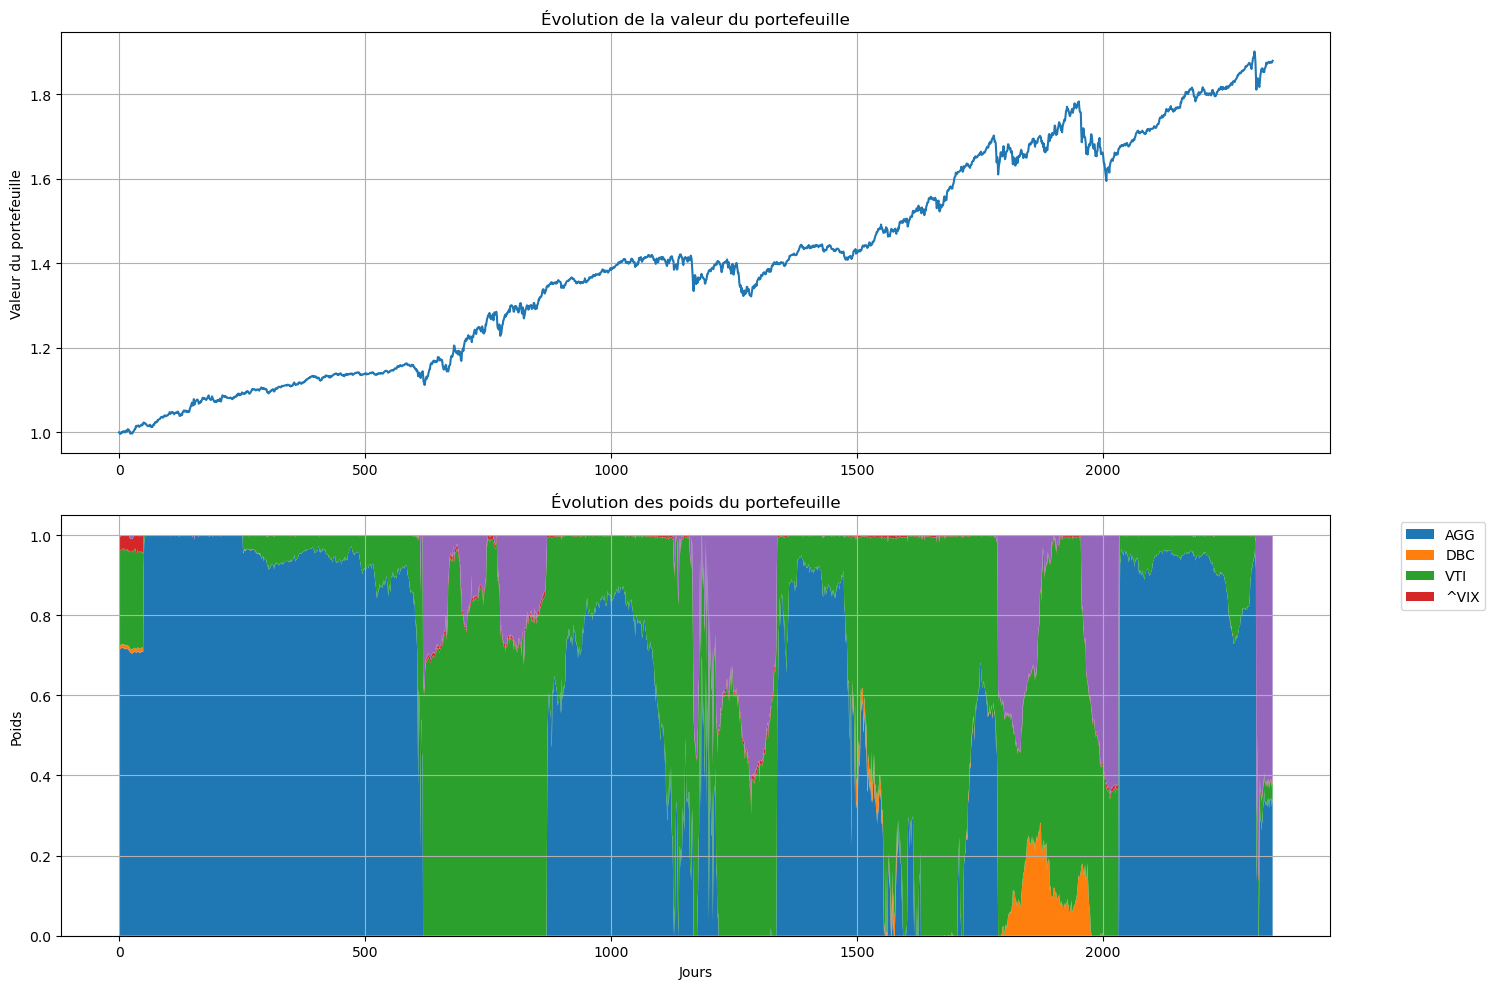

In [49]:
plt.figure(figsize=(15, 10))

# Plot 1: Évolution de la valeur du portefeuille
plt.subplot(2, 1, 1)
plt.plot(portfolio_value_controlled)
plt.title('Évolution de la valeur du portefeuille')
plt.ylabel('Valeur du portefeuille')
plt.grid(True)

# Plot 2: Évolution des poids
plt.subplot(2, 1, 2)
weights_df = pd.DataFrame(weights_actual, columns=tickers+['Cash'])
plt.stackplot(range(len(weights_actual)), weights_df.T, labels=tickers)
plt.title('Évolution des poids du portefeuille controllé')
plt.xlabel('Jours')
plt.ylabel('Poids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
print(f"Performance totale: {returns_vol_mean:.2f}%")
print(f"Volatilité annualisée: {volatility_cont:.2f}%")
print(f"Ratio de Sharpe: {sharpe_ratio_vol:.2f}")


Performance totale: 6.94%
Volatilité annualisée: 5.60%
Ratio de Sharpe: 1.24
